(sec:othello-agent)=
# オセロAIの作成

In [1]:
"""
下準備のコード
"""

%load_ext autoreload
%autoreload 2

import time
import random
import contextlib

import numpy as np
import joblib
import IPython.display as display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.animation import ArtistAnimation

# 乱数シードの固定
random.seed(31415)
np.random.seed(31415)


# joblib用のtqdm
@contextlib.contextmanager
def tqdm_joblib(total=None, **kwargs):
    pbar = tqdm(total=total, miniters=1, smoothing=0, **kwargs)

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            pbar.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield pbar
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        pbar.close()

ここからは、より高度な強化学習の対象としてオセロを取り扱う。ご存じの通り、オセロは(諸説あるものの)日本で発祥した「はさみ碁」の一種で、白と黒のディスクを8×8の盤の上に並べ、同色で挟まれたディスクを裏返すことで、より多くのマスを獲得した方が勝利するというゲームである。

```{warning}
オセロは日本以外ではリバーシのように呼ばれることがある。リバーシは初期状態として、ディスクが置かれていない状態からスタートするが、オセロは盤の中央に白黒2枚ずつのディスクを置いた状態からスタートする、という違いがある。

参考: [オセロ（ボードゲーム）- Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%82%BB%E3%83%AD_(%E3%83%9C%E3%83%BC%E3%83%89%E3%82%B2%E3%83%BC%E3%83%A0))
```

## オセロゲーム環境

今回は、講義用に用意したオセロ用のゲーム環境を用いる。ゲーム環境用のモジュールは以下のURLからダウンロードできる。




このモジュールには大きく分けて、3つのクラスが定義されている。

**Env**はオセロゲームを取り扱う環境で、有効手の列挙や盤の状態の更新などの関数を提供する。ただし、`Env`クラスは直接インスタンス化する代わりに、`gymnasium`と同様に環境作成用の`make`関数が用意されているので、こちらを用いる。

**Move**はオセロゲームにおける「手」を表わすクラスで、現在のプレイヤーとディスクを置く場所を格納している。

**Player**は厳密には列挙型として定義されていて、プレイヤーが黒番なのか白番なのかに加えて、次のプレイヤーに手渡しする関数などが提供されている。

まずは、これらをモジュールからインポートして、ゲーム環境を作成してみる。

In [2]:
# オセロモジュールのインポート
import othello
from othello import Move, Player

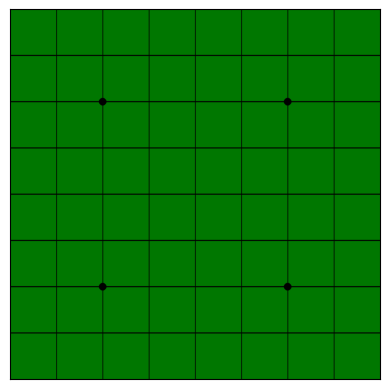

In [3]:
# 環境の作成
env = othello.make()
env

上記のように、オセロ環境は初期状態ではディスクが配置されていない。ここでも`gymnasium`と同様に`reset`関数を呼び出すことで、ゲーム環境が初期化される。

なお、`reset`関数は現在の手番を表わすプレイヤーと、現在の盤面状態を表わすNumPyの配列を返してくる。この点は`gymnasium`と異なっているので注意すること。

In [4]:
player, board = env.reset()

In [5]:
print(player)

Player.BLACK


In [6]:
print(board)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 -1 0 0 0]
 [0 0 0 -1 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


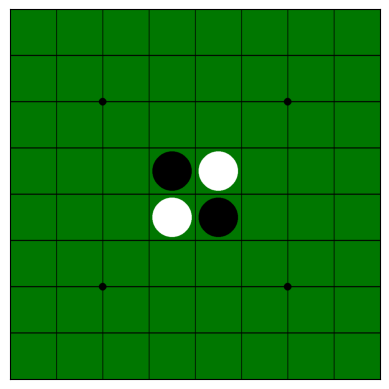

In [7]:
env

また、上記の通り、Jupyter Notebook環境においては`env`を表示することで盤面を表わす画像が表示されるので、適宜、こちらを用いて状態を確認してほしい。

## ランダムな着手

まずは、オセロ環境の仕様を理解するために、白番、黒番ともにランダムに行動させて、どのように状態が変化するかを見てみよう。

`env`には、現在の盤の状態で取ることができる「有効手」の配列を取得する`legal_moves`関数が提供されている。

In [8]:
moves = env.legal_moves(player)
print(moves)

[('BLACK', 3, 5), ('BLACK', 4, 6), ('BLACK', 5, 3), ('BLACK', 6, 4)]


上記の出力から、黒番が3行5列、4行6列、5行3列、6行4列の4箇所のいずれかにディスクを置くことができることが分かる。

着手を決定したら、`env.step`関数に手を表わす変数を渡す。`step`関数は`reset`関数と同様に次の手番を表わすプレイヤーと、現在の盤面の状態を返す。

In [9]:
player, board = env.step(moves[0])

In [10]:
print(player)

Player.WHITE


In [11]:
print(board)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 0 0 -1 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


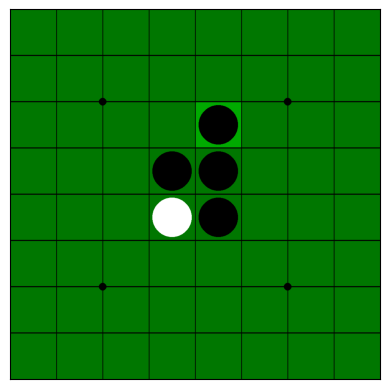

In [12]:
env

このように、黒番が3行5列にディスクを置いたことで、着手したマスがハイライトされて、かつ、盤の状態が正しく更新されていることが確認できる。

オセロはルール上、着手可能な手がない、すなわちどこにディスクを置いても裏返せる相手方のディスクが存在しない時にはパスをすることになる。

有効手が存在しない時には`legal_moves`が空の配列を返してくるので、そのときには`Move.Pass(player)`を呼び出して、パスを表わす「手」を用意する。

```python
moves = env.legal_moves(player)
if len(moves) = 0:
    move = Move.Pass(player)
```

これらを踏まえて、黒番、白番ともにランダムに着手させて、盤の状態変化を確認する。

In [13]:
# ゲームのリセット
player, _ = env.reset()
frames = []

# エピソード開始
while not env.gameset():
    # 有効手の列挙
    moves = env.legal_moves(player)

    # 現在の状態画像を保存
    img = env.render()
    frames.append(img)

    # 着手可能な手があればランダムに1つを選ぶ
    # 選べる手がなければパスする
    if len(moves) != 0:
        move = np.random.choice(moves)
    else:
        move = Move.Pass(player)

    # 着手による盤の状態の更新
    player, _ = env.step(move)

In [14]:
# アニメーションの描画
fig, ax = plt.subplots(dpi=100)
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    draw.append([ims])

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_html5_video())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

最終的な状態において、黒番、白番がそれぞれ何個のセルを専有しているかは`count`関数により計算できる。

In [15]:
# 黒番、白番の獲得セル数がtuple型で与えられる
print("(black, white) =", env.count())

(black, white) = (30, 34)


In [16]:
# 黒番だけ、白番だけも計算可能
print("#black:", env.count(Player.BLACK))
print("#white:", env.count(Player.WHITE))

#black: 30
#white: 34


最後に、両者ランダムに着手する場合に1000回対戦すると、どの程度の勝敗になるのかを調べてみる。

In [17]:
n_episodes = 1000


def match():
    # ゲームのリセット
    env = othello.make()
    player, _ = env.reset()

    # エピソード開始
    while not env.gameset():
        # 有効手の列挙
        moves = env.legal_moves(player)

        # 着手可能な手があればランダムに1つを選ぶ
        # 選べる手がなければパスする
        if len(moves) == 0:
            move = Move.Pass(player)
        else:
            move = np.random.choice(moves)

        # 着手による盤の状態の更新
        player, _ = env.step(move)

    return env.count()


with tqdm_joblib(n_episodes):
    result = joblib.Parallel(n_jobs=-1)(joblib.delayed(match)() for _ in range(n_episodes))

result = np.array(result, dtype="int32")
b_win = np.sum(result[:, 0] > result[:, 1])
w_win = np.sum(result[:, 0] < result[:, 1])
draw = np.sum(result[:, 0] == result[:, 1])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
print("Random vs Random")
print(f"B-win: {b_win:d}, W-win: {w_win:d}, Draw: {draw:d}")

Random vs Random
B-win: 453, W-win: 499, Draw: 48


以下では、利便性のためにランダムに着手する関数として、`move_by_random`を作成しておく。

In [19]:
def move_by_random(env, player):
    moves = env.legal_moves(player)
    if len(moves) == 0:
        return Move.Pass(player)
    else:
        return np.random.choice(moves)

## マス評価値による着手

In [20]:
scores = np.array(
    [
        [100, -40, 20, 5, 5, 20, -40, 100],
        [-40, -80, -1, -1, -1, -1, -80, -40],
        [20, -1, 5, 1, 1, 5, -1, 20],
        [5, -1, 1, 0, 0, 1, -1, 5],
        [5, -1, 1, 0, 0, 1, -1, 5],
        [20, -1, 5, 1, 1, 5, -1, 20],
        [-40, -80, -1, -1, -1, -1, -80, -40],
        [100, -40, 20, 5, 5, 20, -40, 100],
    ],
    dtype="int32",
)

In [21]:
def move_by_score(env, player):
    moves = env.legal_moves(player)
    if len(moves) == 0:
        return Move.Pass(player)
    else:
        best_move = moves[0]
        best_score = -99999
        for move in moves:
            score = scores[move.x, move.y]
            if best_score < score:
                best_move = move
                best_score = score
        return best_move

In [22]:
# ゲームのリセット
player, board = env.reset()
frames = []

# エピソード開始
while not env.gameset():
    # 黒番:
    if player == Player.BLACK:
        # セル評価値が最も高い場所に着手する
        move = move_by_score(env, player)

    # 白番:
    if player == Player.WHITE:
        # 着手可能な手があればランダムに1つを選ぶ
        move = move_by_random(env, player)

    # 着手による盤の状態の更新
    player, _ = env.step(move)

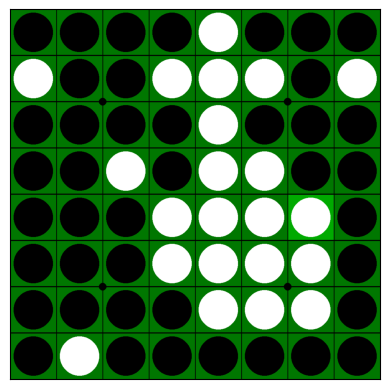

In [23]:
env

In [24]:
n_episodes = 1000


def match():
    # ゲームのリセット
    env = othello.make()
    player, _ = env.reset()

    # エピソード開始
    while not env.gameset():
        # 黒番:
        if player == Player.BLACK:
            # セル評価値が最も高い場所に着手する
            move = move_by_score(env, player)
        # 白番:
        if player == Player.WHITE:
            # 着手可能な手があればランダムに1つを選ぶ
            move = move_by_random(env, player)

        # 着手による盤の状態の更新
        player, _ = env.step(move)

    return env.count()


with tqdm_joblib(n_episodes):
    result = joblib.Parallel(n_jobs=-1)(joblib.delayed(match)() for _ in range(n_episodes))

result = np.array(result, dtype="int32")
b_win = np.sum(result[:, 0] > result[:, 1])
w_win = np.sum(result[:, 0] < result[:, 1])
draw = np.sum(result[:, 0] == result[:, 1])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
print("Cell-score vs Random")
print(f"B-win: {b_win:d}, W-win: {w_win:d}, Draw: {draw:d}")

Cell-score vs Random
B-win: 746, W-win: 213, Draw: 41


## ミニマックス探索による着手

In [26]:
def minimax(env, move, depth, max_depth):
    next_player, _ = env.step(move)

    if depth >= max_depth:
        vfun = np.frompyfunc(lambda e: np.int32(e.value), 1, 1)
        score = move.player.value * np.sum(vfun(env.board) * scores)
    else:
        # 相手にとってのベストスコアを計算
        best_score = -99999
        for next_move in env.legal_moves(next_player):
            score = minimax(env, next_move, depth + 1, max_depth)
            if best_score < score:
                best_score = score

        # 自分にとっては相手のベストスコアは小さい方が良い
        score = -best_score

    env.undo()
    return score

In [27]:
def move_by_minimax(env, player, max_depth=2):
    moves = env.legal_moves(player)
    if len(moves) == 0:
        return Move.Pass(player)

    best_move = moves[0]
    best_score = -99999
    for move in moves:
        score = minimax(env, move, 0, max_depth)
        if best_score < score:
            best_move = move
            best_score = score

    return best_move

In [28]:
# ゲームのリセット
player, _ = env.reset()
frames = []

# エピソード開始
while not env.gameset():
    # 有効手の列挙
    moves = env.legal_moves(player)

    # 現在の状態画像を保存
    img = env.render()
    frames.append(img)

    # 黒番:
    if player == Player.BLACK:
        # ミニマックス探索
        move = move_by_minimax(env, player, 2)
    # 白番:
    if player == Player.WHITE:
        # 着手可能な手があればランダムに1つを選ぶ
        move = move_by_random(env, player)

    # 着手による盤の状態の更新
    player, board = env.step(move)

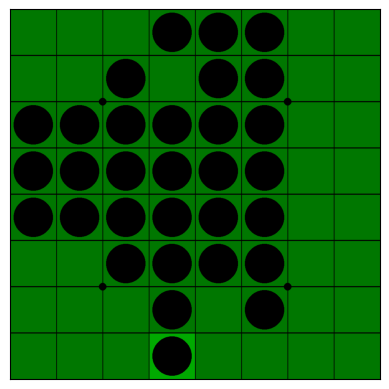

In [29]:
env

In [ ]:
n_episodes = 1000


def match():
    # ゲームのリセット
    env = othello.make()
    player, board = env.reset()

    # エピソード開始
    while not env.gameset():
        # 黒番:
        if player == Player.BLACK:
            # ミニマックス探索
            move = move_by_minimax(env, player, 2)
        # 白番:
        if player == Player.WHITE:
            # 着手可能な手があればランダムに1つを選ぶ
            move = move_by_random(env, player)

        # 着手による盤の状態の更新
        player, _ = env.step(move)

    return env.count()


with tqdm_joblib(n_episodes):
    result = joblib.Parallel(n_jobs=-1)(joblib.delayed(match)() for _ in range(n_episodes))

result = np.array(result, dtype="int32")
b_win = np.sum(result[:, 0] > result[:, 1])
w_win = np.sum(result[:, 0] < result[:, 1])
draw = np.sum(result[:, 0] == result[:, 1])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print("Cell-score vs Random")
print(f"B-win: {b_win:d}, W-win: {w_win:d}, Draw: {draw:d}")

上記の通り、ミニマックス探索で2手先を読むだけで飛躍的に勝率が上昇していることが分かる。

## 発展: アルファベータ探索による着手

In [ ]:
def alpha_beta(env, move, depth, max_depth, limit=99999):
    next_player, _ = env.step(move)

    if depth >= max_depth:
        vfun = np.frompyfunc(lambda e: np.int32(e.value), 1, 1)
        score = move.player.value * np.sum(vfun(env.board) * scores)
    else:
        # 相手にとってのベストスコアを計算
        best_score = -99999
        for next_move in env.legal_moves(next_player):
            score = alpha_beta(env, next_move, depth + 1, max_depth, -best_score)
            if best_score < score:
                best_score = score

            if best_score >= limit:
                break

        # 自分にとっては相手のベストスコアは小さい方が良い
        score = -best_score

    env.undo()
    return score

In [ ]:
def move_by_alpha_beta(env, player, max_depth=2):
    moves = env.legal_moves(player)
    if len(moves) == 0:
        return Move.Pass(player)

    best_move = moves[0]
    best_score = -99999
    for move in moves:
        score = alpha_beta(env, move, 0, max_depth, -best_score)
        if best_score < score:
            best_move = move
            best_score = score

    return best_move

In [ ]:
# ゲームのリセット
player, board = env.reset()
frames = []

# エピソード開始
while not env.gameset():
    # 有効手の列挙
    moves = env.legal_moves(player)

    # 現在の状態画像を保存
    img = env.render()
    frames.append(img)

    # 黒番:
    if player == Player.BLACK:
        # アルファ・ベータ探索
        move = move_by_alpha_beta(env, player, 4)
    # 白番:
    if player == Player.WHITE:
        # 着手可能な手があればランダムに1つを選ぶ
        move = move_by_random(env, player)

    # 着手による盤の状態の更新
    player, board = env.step(move)

In [ ]:
env

In [ ]:
n_episodes = 1000


def match():
    # ゲームのリセット
    env = othello.make()
    player, board = env.reset()

    # エピソード開始
    while not env.gameset():
        # 黒番:
        if player == Player.BLACK:
            # アルファ・ベータ探索
            move = move_by_alpha_beta(env, player, 2)
        # 白番:
        if player == Player.WHITE:
            # 着手可能な手があればランダムに1つを選ぶ
            move = move_by_random(env, player)

        # 着手による盤の状態の更新
        player, _ = env.step(move)

    return env.count()


with tqdm_joblib(n_episodes):
    result = joblib.Parallel(n_jobs=-1)(joblib.delayed(match)() for _ in range(n_episodes))

result = np.array(result, dtype="int32")
b_win = np.sum(result[:, 0] > result[:, 1])
w_win = np.sum(result[:, 0] < result[:, 1])
draw = np.sum(result[:, 0] == result[:, 1])